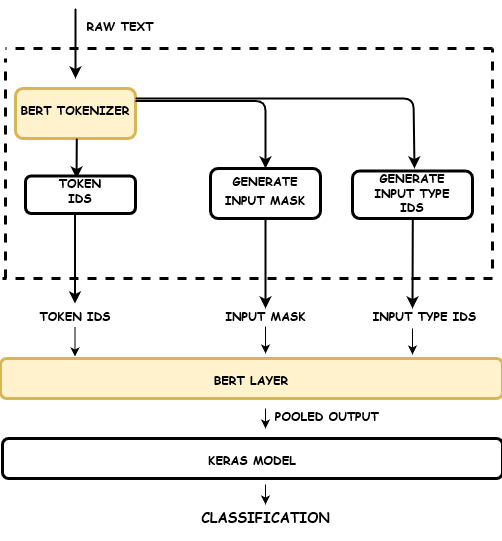

In [ ]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification

import pandas as pd
from bs4 import BeautifulSoup
import re

import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


In [ ]:
df=pd.read_csv('Imdb_Dataset.csv')
df.head()

,sentence,sentiment
0,All the world said that the film Tashan would ...,0
1,Don't let the title trick you into watching th...,0
2,When robot hordes start attacking major cities...,0
3,There's so little here of the fantastic Anne R...,0
4,Twist endings can be really cool in a movie. I...,0


In [ ]:
test_df=pd.read_csv('test_df.csv')
test_df.head()

,sentence,sentiment
0,I saw this movie yesterday and thought it was ...,0
1,"Well, how to make a movie as provocative as po...",0
2,I think Walter Pidgeon was badly miscast in th...,0
3,"First, let me start by saying that I am a Laur...",0
4,Love the TPB's but this was a lame episode. Di...,0


In [ ]:
df['sentiment'].value_counts()

,count
sentiment,
0,12500
1,12500


<Axes: xlabel="{0: 'Negetive', 1: 'Positive'}">

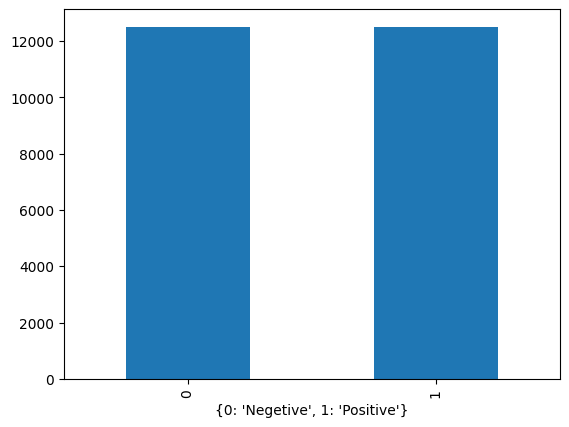

In [ ]:
df['sentiment'].value_counts().plot(kind='bar',xlabel={0:'Negetive',1:'Positive'})


In [ ]:
df['sentence'][0]

'All the world said that the film Tashan would be a good movie with great pleasure, but this is not the case. Vijay Krishna Acharya made a serious mistake to take as an actress Kareena Kapoor. She was unbearable throughout the film. Her tom-boy look does not really goes well. Even the film the story of the film is not making sense at all. Everyone said that the Quetin Taratino of India is Vijay but its not at all Quetin. The talent Anil Kapoor was involved in this stupid movie. Anil is an actor of large caliber and this film is not. Akshay Kumar has also been a victim of this film as all is Saif. The Style and the Phoormola is not really good in this film i was disappointed'

In [ ]:
def text_cleaning(text):
	soup = BeautifulSoup(text, "html.parser")
	text = re.sub(r'\[[^]]*\]', '', soup.get_text())
	pattern = r"[^a-zA-Z0-9\s,']"
	text = re.sub(pattern, '', text)
	return text

In [ ]:
df['Cleaned_sentence'] = df['sentence'].apply(text_cleaning)
test_df['Cleaned_sentence'] = test_df['sentence'].apply(text_cleaning)


In [ ]:
def generate_wordcloud(text,Title):
	all_text = " ".join(text)
	wordcloud = WordCloud(width=800,
						height=400,
						stopwords=set(STOPWORDS),
						background_color='black').generate(all_text)
	plt.figure(figsize=(10, 5))
	plt.imshow(wordcloud, interpolation='bilinear')
	plt.axis("off")
	plt.title(Title)
	plt.show()

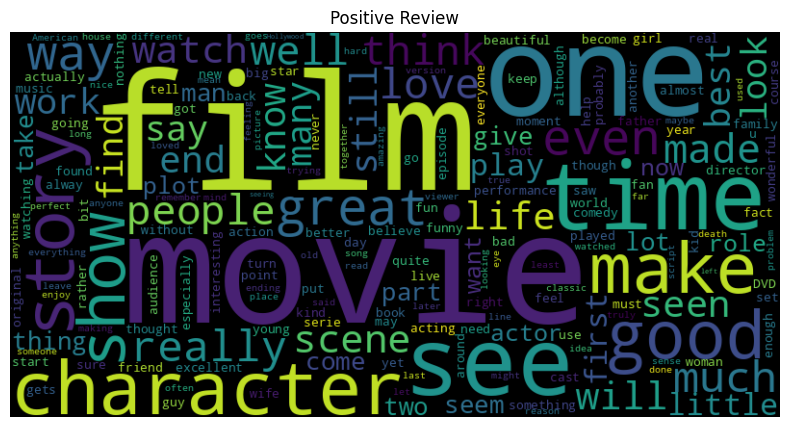

In [ ]:
positive = df[df['sentiment']==1]['Cleaned_sentence'].tolist()
generate_wordcloud(positive,'Positive Review')

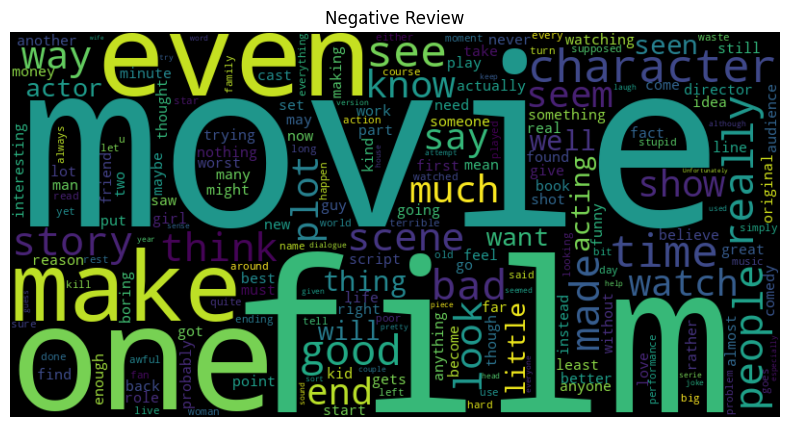

In [ ]:
negative = df[df['sentiment']==0]['Cleaned_sentence'].tolist()
generate_wordcloud(negative,'Negative Review')

In [ ]:
Reviews =df['Cleaned_sentence']
Target = df['sentiment']
test_reviews = test_df['Cleaned_sentence']
test_targets = test_df['sentiment']

x_val, x_test, y_val, y_test = train_test_split(test_reviews,
													test_targets,
													test_size=0.5,
													stratify = test_targets)


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [ ]:
Reviews

,Cleaned_sentence
0,All the world said that the film Tashan would ...
1,Don't let the title trick you into watching th...
2,When robot hordes start attacking major cities...
3,There's so little here of the fantastic Anne R...
4,Twist endings can be really cool in a movie It...
...,...
24995,Another Woo's masterpieceThis is a best wuxie ...
24996,"I watched, entranced and mesmerized, by the vo..."
24997,This is a splendidly done simplistic film that...
24998,When its DVD was released i came to market and...


In [ ]:
max_len= 128
X_train_encoded = tokenizer.batch_encode_plus(Reviews.tolist(),
											padding=True,
											truncation=True,
											max_length = max_len,
											return_tensors='tf')

In [ ]:
X_val_encoded = tokenizer.batch_encode_plus(x_val.tolist(),
											padding=True,
											truncation=True,
											max_length = max_len,
											return_tensors='tf')

X_test_encoded = tokenizer.batch_encode_plus(x_test.tolist(),
											padding=True,
											truncation=True,
											max_length = max_len,
											return_tensors='tf')


In [ ]:
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [ ]:
history = model.fit(
	[X_train_encoded['input_ids'], X_train_encoded['token_type_ids'], X_train_encoded['attention_mask']],
	Target,
	validation_data=(
	[X_val_encoded['input_ids'], X_val_encoded['token_type_ids'], X_val_encoded['attention_mask']],y_val),
	batch_size=32,
	epochs=3
)

Epoch 1/3
782/782 [==============================] - 862s 1s/step - loss: 0.3395 - accuracy: 0.8488 - val_loss: 0.2887 - val_accuracy: 0.8784
Epoch 2/3
782/782 [==============================] - 820s 1s/step - loss: 0.1987 - accuracy: 0.9218 - val_loss: 0.2746 - val_accuracy: 0.8891
Epoch 3/3
782/782 [==============================] - 821s 1s/step - loss: 0.1089 - accuracy: 0.9608 - val_loss: 0.3368 - val_accuracy: 0.8844


In [ ]:
test_loss, test_accuracy = model.evaluate(
	[X_test_encoded['input_ids'], X_test_encoded['token_type_ids'], X_test_encoded['attention_mask']],
	y_test
)
print(f'Test loss: {test_loss}, Test accuracy: {test_accuracy}')

391/391 [==============================] - 114s 292ms/step - loss: 0.3446 - accuracy: 0.8840
Test loss: 0.3445638418197632, Test accuracy: 0.8840000033378601


In [ ]:
model.save_pretrained('sentiment_analysis_model')
tokenizer.save_pretrained('sentiment_analysis_tokenizer')


('sentiment_analysis_tokenizer/tokenizer_config.json',
 'sentiment_analysis_tokenizer/special_tokens_map.json',
 'sentiment_analysis_tokenizer/vocab.txt',
 'sentiment_analysis_tokenizer/added_tokens.json')

In [ ]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification

model = TFBertForSequenceClassification.from_pretrained('sentiment_analysis_model')
tokenizer = BertTokenizer.from_pretrained('sentiment_analysis_tokenizer')


Some layers from the model checkpoint at sentiment_analysis_model were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at sentiment_analysis_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [ ]:
pred = model.predict(
    [X_test_encoded['input_ids'], X_test_encoded['token_type_ids'], X_test_encoded['attention_mask']])

logits = pred.logits

pred_labels = tf.argmax(logits, axis=1)

pred_labels = pred_labels.numpy()

label = {
    1: 'positive',
    0: 'Negative'
}

pred_labels = [label[i] for i in pred_labels]
Actual = [label[i] for i in y_test]

print('Predicted Label :', pred_labels[:10])
print('Actual Label    :', Actual[:10])


391/391 [==============================] - 118s 294ms/step
Predicted Label : ['positive', 'Negative', 'positive', 'Negative', 'positive', 'positive', 'Negative', 'Negative', 'positive', 'positive']
Actual Label    : ['positive', 'positive', 'positive', 'Negative', 'positive', 'positive', 'Negative', 'positive', 'positive', 'positive']


In [ ]:
print("Classification Report: \n", classification_report(Actual, pred_labels))


Classification Report: 
               precision    recall  f1-score   support

    Negative       0.88      0.89      0.88      6250
    positive       0.89      0.88      0.88      6250

    accuracy                           0.88     12500
   macro avg       0.88      0.88      0.88     12500
weighted avg       0.88      0.88      0.88     12500



In [ ]:
def Get_sentiment(Review, Tokenizer=tokenizer, Model=model):
    if not isinstance(Review, list):
        Review = [Review]

    Input_ids, Token_type_ids, Attention_mask = Tokenizer.batch_encode_plus(Review,
                                                                             padding=True,
                                                                             truncation=True,
                                                                             max_length=128,
                                                                             return_tensors='tf').values()
    prediction = Model.predict([Input_ids, Token_type_ids, Attention_mask])

    pred_labels = tf.argmax(prediction.logits, axis=1)
    pred_labels = [label[i] for i in pred_labels.numpy().tolist()]
    return pred_labels


In [ ]:
Review ='''this movie was ok  '''
Get_sentiment(Review)


1/1 [==============================] - 0s 70ms/step


['positive']